# Timeseries project

# Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Real data

In [2]:
# Set seed
random_SEED = 42

Load data and relabel column with labels.

Label = 1: Healthy

Label = 2, 3, 4, 5: Unhealthy.

In [3]:
# Load data
train_set = pd.read_csv('ECG5000/ECG5000_TRAIN.txt', delim_whitespace=True, header=None)
test_set = pd.read_csv('ECG5000/ECG5000_TEST.txt', delim_whitespace=True, header=None)

# Rename column
train_set.rename(columns = {0:'Label'}, inplace=True)
test_set.rename(columns = {0:'Label'}, inplace=True)

# Save detailed labels
all_labels = {'Train': train_set['Label'].copy(), 'Test': test_set['Label'].copy()}

# Rename to 0=unhealthy, 1=healthy
train_set['Label'][train_set['Label']!=1] = 0

# Rename to 0=unhealthy, 1=healthy
test_set['Label'][test_set['Label']!=1] = 0

Normalize data

In [4]:
# Select columns to normalize (all columns except 'Label')
columns_to_normalize = train_set.columns.difference(['Label'])

min_val = train_set[columns_to_normalize].min()
max_val = train_set[columns_to_normalize].max()

# Normalize the selected columns in the train set
train_set[columns_to_normalize] = (train_set[columns_to_normalize] - min_val) / (max_val - min_val)

# Normalize the selected columns in the test set
test_set[columns_to_normalize] = (test_set[columns_to_normalize] - min_val) / (max_val - min_val)

Set sequence length

In [5]:
sequence_length = train_set.shape[1]-1 # -1 due to the label

Split the train sets into several trainsets for each autoencoder

In [6]:
num_splits = 5

patient_IDs_train = train_set.index 

# Set a random seed for reproducibility
np.random.seed(random_SEED)

train_datasets = []
train_labels = []

# Create a copy of the IDs to sample from without replacement
remaining_IDs = patient_IDs_train.copy()

for i in range(num_splits):
    if i == num_splits - 1:  # For the last split, take all remaining IDs
        split = remaining_IDs
    else:
        split = np.random.choice(remaining_IDs, size=len(patient_IDs_train) // num_splits, replace=False)
        # Remove sampled IDs from remaining IDs
        remaining_IDs = np.setdiff1d(remaining_IDs, split)
    
    i_train_set = train_set.loc[train_set.index.isin(split)]
    i_train_set.index = pd.RangeIndex(len(i_train_set.index))
    train_datasets.append(i_train_set.drop(labels=['Label'],axis=1)) # Split labels from data
    train_labels.append(i_train_set['Label'])

In [7]:
train_data_torch = torch.tensor(np.array(train_set.drop(labels=['Label'], axis=1), dtype=np.float32))
test_data_torch = torch.tensor(np.array(test_set.drop(labels=['Label'], axis=1), dtype=np.float32))

# Define autoencoder

Define the autoencoder

In [8]:
# Define the Autoencoder Model
class TimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(TimeSeriesAutoencoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, encoding_dim)
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
# Extract Encoder
class Encoder(nn.Module):
    def __init__(self, original_autoencoder):
        super(Encoder, self).__init__()
        # Copy encoder layers from the trained autoencoder
        self.encoder = original_autoencoder.encoder

    def forward(self, x):
        return self.encoder(x)

In [10]:
def train_data_loader(split, train_datasets):
    
    train_data = train_datasets[split]
    train_data = np.array(train_data, dtype=np.float32)

    train_dataset = TensorDataset(torch.tensor(train_data))
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    return(train_dataloader)

In [11]:
# Train the Autoencoder
def training_loop(num_epochs, dataloader, model, optimizer, criterion):
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in dataloader:
            inputs = batch[0]

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, inputs)  # MSE between output and input

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Print average loss
        if epoch % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}")
    
    return model

# Train the autoencoder

Define model parameters

In [12]:
# Model parameters
input_dim = sequence_length
encoding_dim = 8  # Dimension of the encoded representation

# Loss function and optimizer
criterion = nn.MSELoss()

# Number of training epochs
num_epochs = 500

Train the ensamble of autoencoders

In [13]:
models = []

for i in range(num_splits):
    model = TimeSeriesAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    dataloader = train_data_loader(i, train_datasets)
    
    model = training_loop(num_epochs, dataloader, model, optimizer, criterion)
    
    models.append(model)

Epoch [1/500], Loss: 0.3160
Epoch [101/500], Loss: 0.0104
Epoch [201/500], Loss: 0.0079
Epoch [301/500], Loss: 0.0061
Epoch [401/500], Loss: 0.0051
Epoch [1/500], Loss: 0.3104
Epoch [101/500], Loss: 0.0099
Epoch [201/500], Loss: 0.0062
Epoch [301/500], Loss: 0.0054
Epoch [401/500], Loss: 0.0046
Epoch [1/500], Loss: 0.3059
Epoch [101/500], Loss: 0.0076
Epoch [201/500], Loss: 0.0046
Epoch [301/500], Loss: 0.0044
Epoch [401/500], Loss: 0.0034
Epoch [1/500], Loss: 0.2776
Epoch [101/500], Loss: 0.0070
Epoch [201/500], Loss: 0.0051
Epoch [301/500], Loss: 0.0043
Epoch [401/500], Loss: 0.0035
Epoch [1/500], Loss: 0.2822
Epoch [101/500], Loss: 0.0078
Epoch [201/500], Loss: 0.0038
Epoch [301/500], Loss: 0.0032
Epoch [401/500], Loss: 0.0030


Train one model on all data

In [14]:
model = TimeSeriesAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(train_data_torch)
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = training_loop(num_epochs, dataloader, model, optimizer, criterion)

Epoch [1/500], Loss: 0.2818
Epoch [101/500], Loss: 0.0043
Epoch [201/500], Loss: 0.0029
Epoch [301/500], Loss: 0.0026
Epoch [401/500], Loss: 0.0024


# Evaluation

Evaluation of the single model

In [15]:
# Evaluate the Autoencoder on test data
model.eval()  # Set model to evaluation mode

with torch.no_grad():
    reconstructed = model(test_data_torch)
    mse = criterion(model(test_data_torch), test_data_torch)
    print(mse)

tensor(0.0032)


Evaluation of the ensamble

In [16]:
reconstructed_per_model = []
with torch.no_grad():
    for i in range(num_splits):
        i_model = models[i]
        i_model.eval()  # Set model to evaluation mode

        reconstructed_per_model.append(i_model(test_data_torch).numpy())

    reconstructed_mean = np.array(reconstructed_per_model).mean(axis=0)
    mse_mean = criterion(torch.tensor(reconstructed_mean), test_data_torch)
    print(mse_mean)

tensor(0.0042)


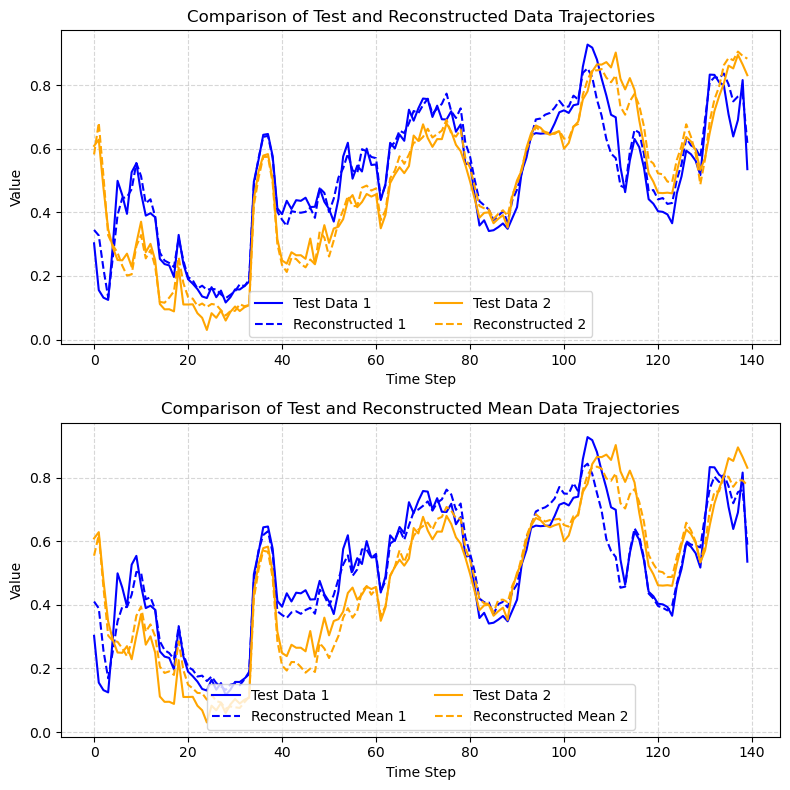

In [17]:
colors = ['blue', 'orange', 'green']

fig, axes = plt.subplots(2, 1, figsize=(8, 8))  # Create 2 subplots vertically stacked

# First plot: Test Data vs Reconstructed
for i, j in enumerate([1, 2]):  # Plot three trajectories
    axes[0].plot(test_data_torch[j], label=f'Test Data {i+1}', linestyle='-', color=colors[i])
    axes[0].plot(reconstructed[j], label=f'Reconstructed {i+1}', linestyle='--', color=colors[i])

axes[0].set_title("Comparison of Test and Reconstructed Data Trajectories")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Value")
axes[0].legend(loc='lower center', ncol=2)
axes[0].grid(True, linestyle='--', alpha=0.5)

# Second plot: Test Data vs Reconstructed Mean
for i, j in enumerate([1, 2]):  # Plot three trajectories
    axes[1].plot(test_data_torch[j], label=f'Test Data {i+1}', linestyle='-', color=colors[i])
    axes[1].plot(reconstructed_mean[j], label=f'Reconstructed Mean {i+1}', linestyle='--', color=colors[i])

axes[1].set_title("Comparison of Test and Reconstructed Mean Data Trajectories")
axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("Value")
axes[1].legend(loc='lower center', ncol=2)
axes[1].grid(True, linestyle='--', alpha=0.5)

# Adjust layout and show plot
plt.tight_layout()  # Ensure the subplots do not overlap
plt.show()


# Anomaly detection using 1 model

Choose a threshold value that is one standard deviations above the mean.

In [18]:
def find_threshold(model, data):
    
    model.eval()  # Set model to evaluation mode

    # Remove the avereging
    criterion = nn.MSELoss(reduction='none')

    with torch.no_grad():
        reconstructed = model(data)
        mse = criterion(model(data), data).mean(axis=1).numpy()

    threshold = mse.mean() + mse.std()
    #threshold = np.percentile(mse, 95)
    #mse_log = np.log1p(mse)  # log(1 + x) to handle zero values
    #threshold = np.mean(mse_log) + np.std(mse_log)
    return threshold, mse

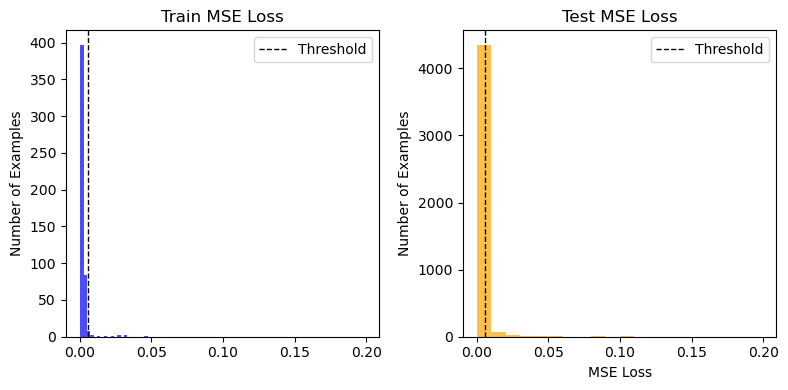

In [19]:
threshold, mse_train = find_threshold(model, train_data_torch)
_, mse_test = find_threshold(model, test_data_torch)

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True)  # Create 2 vertical subplots

# Plot the training histogram
axes[0].hist(mse_train, bins=20, color='blue', alpha=0.7)
axes[0].axvline(threshold, color='k', linestyle='dashed', linewidth=1, label="Threshold")
axes[0].set_title("Train MSE Loss")
axes[0].set_ylabel("Number of Examples")
axes[0].legend()

# Plot the testing histogram
axes[1].hist(mse_test, bins=20, color='orange', alpha=0.7)
axes[1].axvline(threshold, color='k', linestyle='dashed', linewidth=1, label="Threshold")
axes[1].set_title("Test MSE Loss")
axes[1].set_xlabel("MSE Loss")
axes[1].set_ylabel("Number of Examples")
axes[1].legend()

# Adjust layout and show
plt.tight_layout()
plt.show()

In [20]:
def predict(model, data, threshold):
    model.eval()  # Set model to evaluation mode

    criterion = nn.MSELoss(reduction='none')
    
    with torch.no_grad():
        reconstructed = model(test_data_torch)
        mse = criterion(model(test_data_torch), test_data_torch).mean(axis=1).numpy()
    
    predictions = np.where(mse > threshold, 0, 1)
    return predictions

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))
    

In [21]:
predictions = predict(model, test_data_torch, threshold)
print_stats(predictions, test_set['Label'])

Accuracy = 0.5893333333333334
Precision = 0.5920151193007324
Recall = 0.953939855348306


# Anomaly detection using an ensemble

In [22]:
predictions = [] 
for i in range(num_splits):
    i_model = models[i]
    i_labels = train_labels[i]
    predictions.append(predict(i_model, test_data_torch, threshold))
    
predictions = np.array(predictions)   
    

In [23]:
# If the predictions are on average classified as an anomaly, label it as an anolaly (0)
final_predictions = np.where(predictions.mean(axis=0) < 0.5, 0, 1)

print_stats(final_predictions, test_set['Label'])

Accuracy = 0.6242222222222222
Precision = 0.6252676659528907
Recall = 0.8892272554244385


# Apply encoder and visualise latent space

In [24]:
# Initialize encoder with the trained autoencoder's encoder part
encoder = Encoder(model)

# Generate Latent Representations
# Set the encoder to evaluation mode
encoder.eval()

# Pass the training data through the encoder to get the latent representations
with torch.no_grad():
    latent_representations_test = encoder(test_data_torch).numpy()  # Shape: (num_samples, encoding_dim)


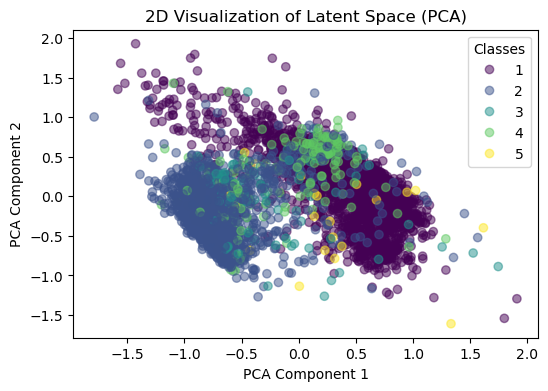

In [25]:
# Apply PCA to Reduce to 2D
# We use PCA to reduce the latent representations to 2D for visualization
pca = PCA(n_components=2)
latent_2d_test = pca.fit_transform(latent_representations_test)  # Shape: (num_samples, 2)

# Plot the 2D Latent Space
plt.figure(figsize=(6, 4))

# Scatter plot
scatter = plt.scatter(
    latent_2d_test[:, 0], latent_2d_test[:, 1],
    c=all_labels['Test'], alpha=0.5
)

# Add legend
unique_labels = np.unique(all_labels['Test']).astype(int)
handles = [plt.Line2D([0], [0], marker='o', color=scatter.cmap(scatter.norm(label)), linestyle='', alpha=0.5)
           for label in unique_labels]
plt.legend(handles, unique_labels, title="Classes")

# Add title and labels
plt.title("2D Visualization of Latent Space (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [26]:
# Convert Torch tensors to Pandas DataFrames
#latent_df = pd.DataFrame(latent_representations_test)
#latent_df["Label"] = all_labels['Test'].astype(int)

# Get the default matplotlib colors
#default_colors = [plt.get_cmap("tab10")(i) for i in range(len(unique_labels))]

# Pairplot using the same default colors
#palette = dict(zip(unique_labels, default_colors))  # Map each label to its color
#sns.pairplot(latent_df, hue="Label", diag_kind="kde", palette=palette)
#plt.show()